In [6]:
%matplotlib inline

In [7]:
import os

from datetime import datetime
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, feature
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
from skimage import img_as_float
import cv2




def image_show(image, nrows=1, ncols=1, cmap='gray', figsize=(16,16), **kwargs):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [8]:
IMAGES_DIRECTORY = 'images/raw'

In [9]:
image_files = os.listdir(IMAGES_DIRECTORY)

In [5]:
filename = os.path.join(IMAGES_DIRECTORY, image_files[0])
carpet_photo = io.imread(filename)

In [ ]:
image_show(carpet_photo)

In [ ]:
bw_photo = color.rgb2grey(carpet_photo)
image_show(bw_photo)

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(bw_photo.ravel(), bins=32)
ax.set_xlim(0, 1);

In [ ]:
photo_otsu_thresholded = filters.threshold_otsu(image=bw_photo)
image_show(bw_photo < photo_otsu_thresholded)

In [ ]:
photo_li_thresholded = filters.threshold_li(image=bw_photo)
image_show(bw_photo < photo_li_thresholded);

In [ ]:
thresholded_image = np.empty(carpet_photo.shape)
for channel_ind in range(3):
    single_channel_photo = carpet_photo[:,:,channel_ind]
    channel_threshold = filters.threshold_otsu(image=single_channel_photo)
    thresholded_image[:, :, channel_ind] = single_channel_photo < channel_threshold 
image_show(thresholded_image)
    

In [ ]:
photo_slic = seg.slic(carpet_photo)
image_show(color.label2rgb(photo_slic, photo, kind='avg'));

In [ ]:
photo_slic = seg.slic(thresholded_image)
image_show(color.label2rgb(photo_slic, thresholded_image, kind='avg'));

In [ ]:
# single_channel_image = 1-thresholded_image[:, :, 1]
# # Compute the Canny filter for two values of sigma
# edges1 = feature.canny(single_channel_image, sigma=0.001)
# edges2 = feature.canny(single_channel_image, sigma=100)

# # display results
# fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 16),
#                                     sharex=True, sharey=True)

# ax1.imshow(single_channel_image, cmap=plt.cm.gray)
# ax1.axis('off')
# ax1.set_title('noisy image', fontsize=20)

# ax2.imshow(edges1, cmap=plt.cm.gray)
# ax2.axis('off')
# ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

# ax3.imshow(edges2, cmap=plt.cm.gray)
# ax3.axis('off')
# ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

# fig.tight_layout()

# plt.show()

In [ ]:
from skimage import data

In [ ]:
image_show(data.coins())

In [ ]:
image_show(bw_photo)

In [ ]:

for high_threshold in  [0.001, 0.01, 0.1]:
    for low_threshold in [0.001, 0.01, 0.1]:
        print(high_threshold, low_threshold)
        image_show(feature.canny(bw_photo, 
                                 high_threshold=high_threshold,
                                 low_threshold=low_threshold),
                  figsize=(4,6))
        plt.show()

In [ ]:

elevation_map = filters.sobel(bw_photo)

fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('elevation map')
ax.axis('off')

In [ ]:
hist = np.histogram(bw_photo)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(bw_photo, cmap=plt.cm.gray, interpolation='nearest')
axes[0].axis('off')
axes[1].plot(hist[1][:-1], hist[0], lw=2)
axes[1].set_title('histogram of gray values')

In [ ]:
image_show(bw_photo> 0.6)

In [ ]:

elevation_map = filters.sobel(bw_photo > 0.6)

fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('elevation map')
ax.axis('off')

In [ ]:
image_show(data.coins())

## Add blur to the image before edge finding to reduce spurious edges

In [ ]:
# gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)

# @interact(blur=(0, 100))
# def blur_tester(blur):
#     blurred = cv2.medianBlur(gray, blur)
#     image_show(blurred)


In [ ]:
# Blurring the image can reduce spurious edges.  How much is appropriate?
gray = cv2.cvtColor(carpet_photo, cv2.COLOR_BGR2GRAY)
image_show(gray)
plt.show()
for blur in [3, 15, 39, 61]:
    print(blur)
    gray = cv2.cvtColor(carpet_photo, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, blur)
    image_show(blurred)
    plt.show()


In [ ]:
ratio_threshold = 0.015
BLUR = 61

# Pre-processing: Convert frame to standard size, 1024x768
gray = cv2.cvtColor(carpet_photo, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, BLUR)
edges = cv2.Canny(gray, 10, 25)
_, contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
size = carpet_photo.shape[0]* carpet_photo.shape[1]

possibles = []
for c in contours:
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    area = cv2.contourArea(box)
    ratio = area / size
    if ratio < ratio_threshold: # Any contour large enough is a candidate
        continue
    # Mark this box as possible card
    else:
        possibles.append(c)
print(ratio_threshold, len(possibles))
image_show(cv2.drawContours(carpet_photo, possibles, -1, (0,255,0), 3))


   

## Code used to output segment files with timestamps


In [10]:
black_background_filename = 'IMG_20180916_120326.jpg'
filename = os.path.join(IMAGES_DIRECTORY, black_background_filename)
lack_photo = io.imread(filename)

(<Figure size 1152x1152 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12df3d0f0>)

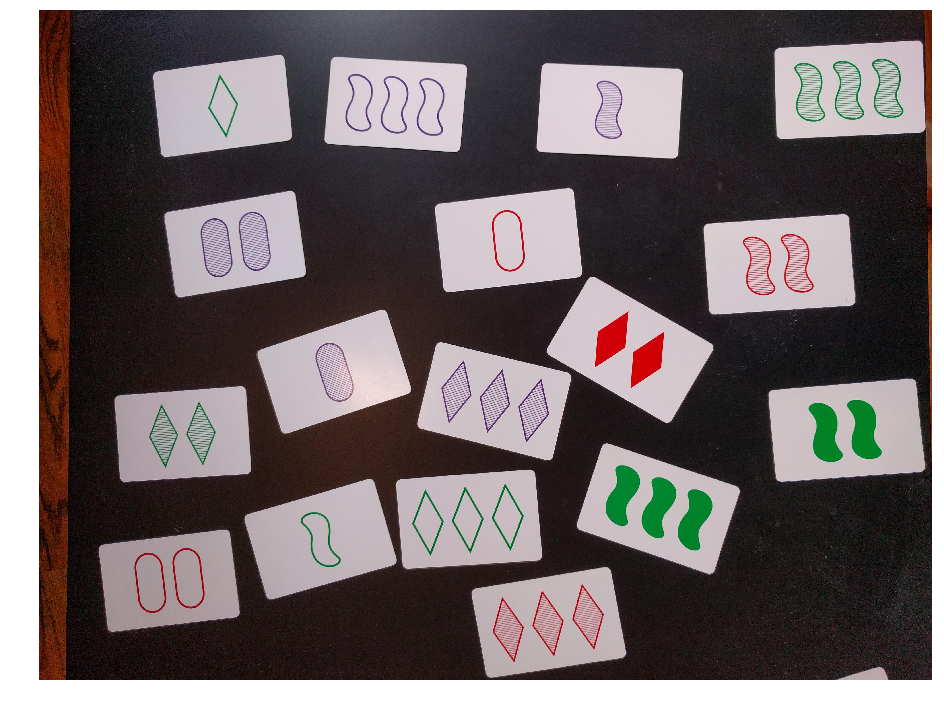

In [11]:
image_show(lack_photo)

In [12]:
RATIO_THRESHOLD = 0.015
BLUR = 15

def find_cards_in_image(image):
    # Pre-processing: Convert frame to standard size, 1024x768
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, BLUR)
    edges = cv2.Canny(gray, 10, 25)
    _, contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    size = image.shape[0]* image.shape[1]

    possible_cards = []
    for contour in contours:
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        area = cv2.contourArea(box)
        ratio = area / size
        if ratio < RATIO_THRESHOLD: # Any contour large enough is a candidate
            continue
        # Mark this box as possible card
        else:
            possible_cards.append(contour)
    # draw segment outline in green
    image_show(cv2.drawContours(image, possible_cards, -1, color=(0,255,0), thickness=3))
    return possible_cards


   

In [13]:
# ## def find_bounding_rectangles_for_possible_cards(possible_cards):
#     """
#     :param possible_cards: list of CV2 contours
#     """
#     # find bounding rectangles for the segments
#     for cnt in possible_cards:
#         rect = list(cv2.minAreaRect(cnt))
#         # scale the width and height of the bounding rectangle.  Need to mutate, so make list
#         rect[1] = [x*1.2 for x in rect[1]]
#         # boxPoints demands tuple (wtf?), so convert back
#         rect = tuple(rect)
#         box = cv2.boxPoints(rect)
#         box = np.int0(box)
#         # draw bounding box in blue
#         cv2.drawContours(lack_photo,[box],0,(0,0,255),3)
        


In [14]:
# image_show(lack_photo)

In [15]:
def save_bounded_rectangle_images_around_possible_cards(possible_cards, image, rectangle_mult=1.2):
    """
    :param possible_cards: list of CV2 contours
    :param rectangle_mult: float multiplier of the card estimated shape for the bounding box size
    """
    # adapted from https://stackoverflow.com/questions/37177811/crop-rectangle-returned-by-minarearect-opencv-python
    mult = 1.2   # I wanted to show an area slightly larger than my min rectangle set this to one if you don't
    for contour in possible_cards:

        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        W = rect[1][0]
        H = rect[1][1]

        Xs = [i[0] for i in box]
        Ys = [i[1] for i in box]
        x1 = min(Xs)
        x2 = max(Xs)
        y1 = min(Ys)
        y2 = max(Ys)

        rotated = False
        angle = rect[2]

        if angle < -45:
            angle+=90
            rotated = True

        center = (int((x1+x2)/2), int((y1+y2)/2))
        size = (int(mult*(x2-x1)),int(mult*(y2-y1)))

        M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

        cropped = cv2.getRectSubPix(image, size, center)    
        cropped = cv2.warpAffine(cropped, M, size)

        croppedW = W if not rotated else H 
        croppedH = H if not rotated else W

        croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW*mult), int(croppedH*mult)), (size[0]/2, size[1]/2))

        plt.imshow(croppedRotated)
        filename = datetime.utcnow().strftime('%Y_%m_%d_%H_%M_%S_%f')
        plt.savefig(os.path.join('images', 'segmented', '%s.png' % filename), bbox_inches='tight')



In [5]:
# black_background_filename = 'IMG_20180916_120326.jpg'
# filename = os.path.join(IMAGES_DIRECTORY, black_background_filename)
# lack_photo = io.imread(filename)

# possible_cards = find_cards_in_image(lack_photo.copy())
# save_bounded_rectangle_images_around_possible_cards(possible_cards, lack_photo)

NameError: name 'os' is not defined

KeyboardInterrupt: 

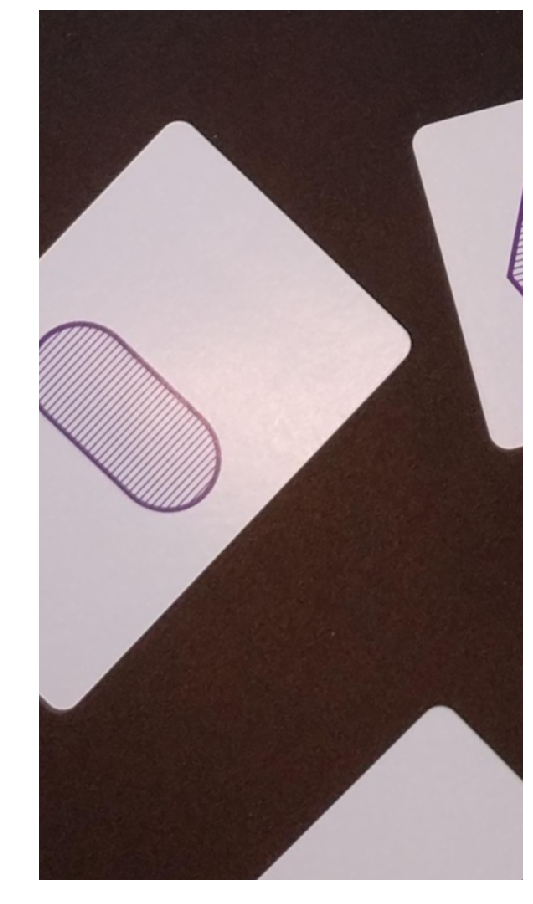

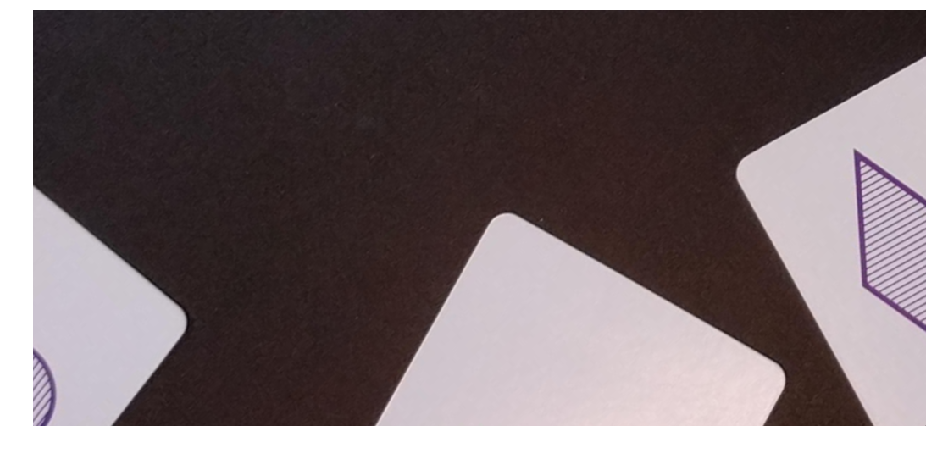

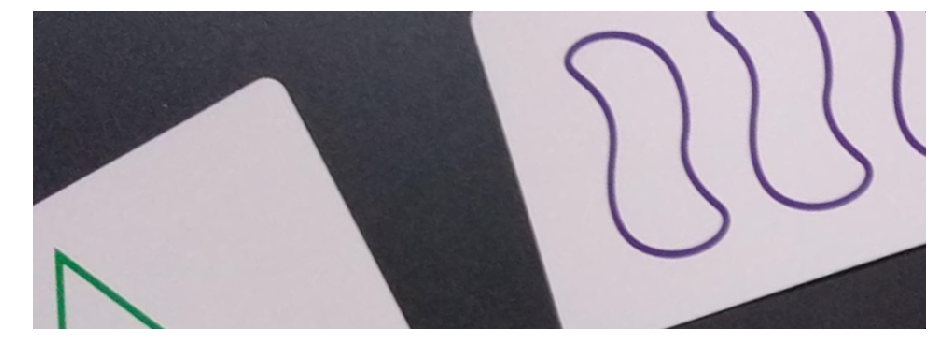

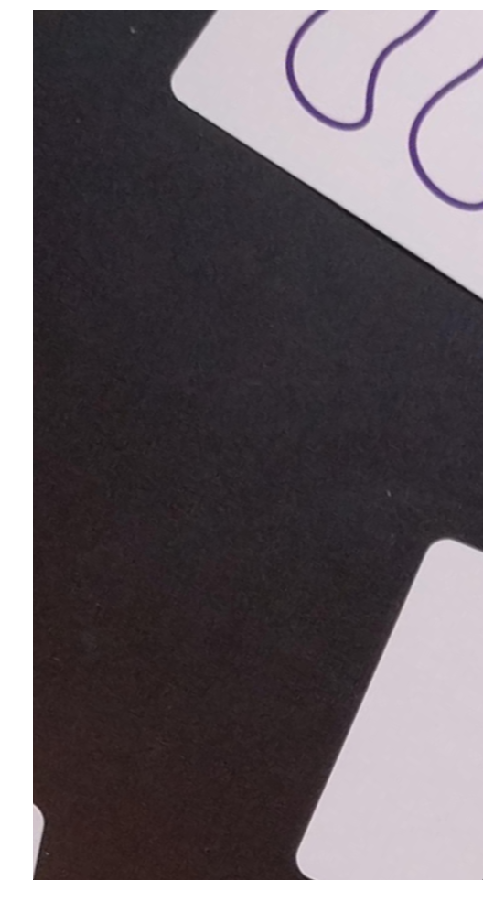

In [16]:
image_files = os.listdir(IMAGES_DIRECTORY)
for image_file in image_files:
    filename = os.path.join(IMAGES_DIRECTORY, image_file)
    loaded_file = io.imread(filename)
    possible_cards = find_cards_in_image(loaded_file.copy())
    save_bounded_rectangle_images_around_possible_cards(possible_cards, lack_photo)